# Challenges with Effect Heterogeneity and Binary Outcomes
 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")


In [2]:
from typing import List

import numpy as np
import pandas as pd
from toolz import curry, partial

@curry
def avg_treatment_effect(df, treatment, outcome):
    return df.loc[df[treatment] == 1][outcome].mean() - df.loc[df[treatment] == 0][outcome].mean()
    
    

@curry
def cumulative_effect_curve(df: pd.DataFrame,
                            treatment: str,
                            outcome: str,
                            prediction: str,
                            min_rows: int = 30,
                            steps: int = 100,
                            effect_fn = avg_treatment_effect) -> np.ndarray:
    
    size = df.shape[0]
    ordered_df = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_rows, size, size // steps)) + [size]
    return np.array([effect_fn(ordered_df.head(rows), treatment, outcome) for rows in n_rows])


@curry
def cumulative_gain_curve(df: pd.DataFrame,
                          treatment: str,
                          outcome: str,
                          prediction: str,
                          min_rows: int = 30,
                          steps: int = 100,
                          effect_fn = avg_treatment_effect) -> np.ndarray:
    

    size = df.shape[0]
    n_rows = list(range(min_rows, size, size // steps)) + [size]

    cum_effect = cumulative_effect_curve(df=df, treatment=treatment, outcome=outcome, prediction=prediction,
                                         min_rows=min_rows, steps=steps, effect_fn=effect_fn)

    return np.array([effect * (rows / size) for rows, effect in zip(n_rows, cum_effect)])


Here is an incredibly comon problem you might face if you find yourself working for a tech company: management wants to boost customer conversion to your product by means of some sort of nudge. For examply, they might want to increase number of app installs by offering a 10 BRL voucher for you to make in app purchases. Or offer you a free ride the first time you use their ride sharing app. Or decrease transactions fees in the first three months that you use their investment plataform. Now, because the nudge is often expensive, they would love to not have to do it for everyone. Rather, it would be great if we could use the conversion boosting nudge only on those customers who are most sensitive to it.

In causal inference terms, you can probably tell by now that this type of business problem falls unde the treatment effect heterogeneity (TEH) umbrela. Specifically, you have a costly nudge as the treatment $T$, conversion as the binary outcome $Y$ and customer specific pre treatment features as $X$. You could then estimate the conditional average treatment effect $E[Y_1 - Y_0|X]$ (or $E[Y'(T)|X]$ if the treatment is continuous)$ with something like Double/Debiased ML and finally target with the nudge only the customers with the highest estimated treatment effect. In business terms, you would be personalizing your conversion strategy. You would be finding a segment of customers with high conversion incrementality and usnig nudges only in them.

If you've remember Part II of the book, you know this is probably the go-to solution. However, there is one complication here that makes the TEH approach not so obvious. 

In [3]:
np.random.seed(42)

n = 100000
nudge = np.random.binomial(1, 0.5, n)
age = np.random.gamma(10, 4, n)
estimated_income = np.random.gamma(20, 2, n)*100

latent_outcome = np.random.normal(-4.5 + estimated_income*0.001 + nudge + nudge*age*0.01)

In [4]:
conversion = (latent_outcome > 0).astype(int)

df = pd.DataFrame(dict(conversion=conversion,
                       nudge=nudge,
                       age=age,
                       estimated_income=estimated_income,
                       latent_outcome=latent_outcome))

print("Avg. Conversion: ", df["conversion"].mean())
df.head()

Avg. Conversion:  0.5444


,conversion,nudge,age,estimated_income,latent_outcome
0,0,0,50.122447,3098.260748,-0.869523
1,0,1,79.314411,3190.136369,-0.388433
2,1,1,59.239808,3867.869980,0.271970
3,0,1,25.415472,3784.975430,-0.430817
4,0,0,40.256898,5509.390963,-1.052747


In [5]:
df.groupby("nudge")[["latent_outcome", "conversion"]].mean()

,latent_outcome,conversion
nudge,,
0,-0.502578,0.346557
1,0.889244,0.741721


In [6]:
avg_treatment_effect(df, "nudge", "latent_outcome")

1.3918215706463832

In [7]:
avg_treatment_effect(df, "nudge", "conversion")

0.39516347253283457

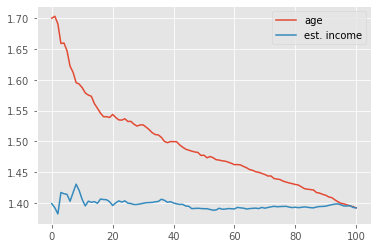

In [8]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "latent_outcome", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()

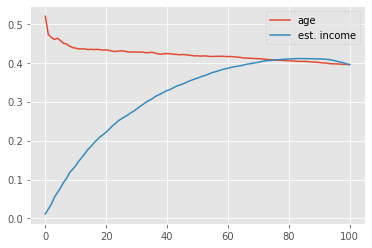

In [9]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()

In [10]:
df["conversion_low"] = conversion = (latent_outcome > 2).astype(int)
df["conversion_high"] = conversion = (latent_outcome > -2).astype(int)

print("Avg. Low Conversion: ", df["conversion_low"].mean())
print("Avg. High Conversion: ", df["conversion_high"].mean())

Avg. Low Conversion:  0.11949
Avg. High Conversion:  0.92854


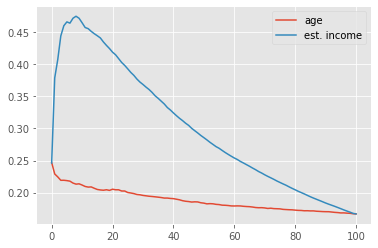

In [11]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_low", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()

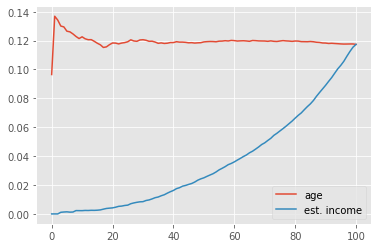

In [12]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_high", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()